In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.nn import BCEWithLogitsLoss
from transformers import LongformerTokenizerFast, \
LongformerModel, LongformerConfig, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers.models.longformer.modeling_longformer import LongformerPreTrainedModel, LongformerClassificationHead
from torch.utils.data import Dataset, DataLoader
import random

from collections import defaultdict
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
data_dir = ''
data_path = 'export.csv'

In [ ]:
df = pd.read_csv(data_path) # , nrows = 5000
df['labels'] = df['VOC_CONCEPT'].apply(lambda x: x.split('|'))
df = df[['CELEX', 'Text', 'labels']]
df.head()

,CELEX,Text,labels
0,21972A0722(03),21972A0722(03) Agreement between the European ...,"[Switzerland, trading operation, customs dutie..."
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, tariff policy, agreement (EU), access..."
2,21981A0710(02),21981A0710(02) Exchange of letters between the...,"[Hungary, trade agreement (EU), goatmeat, shee..."
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, protocol to an agr..."
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, customs harmonisati..."


In [ ]:
print(f"There are {len(df)} rows in the dataset.")

There are 257816 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(df["Text"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Text.")

There are 191 duplicate Text.


In [ ]:
df = df[~df["Text"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 257625 rows in the deduplicated dataset.


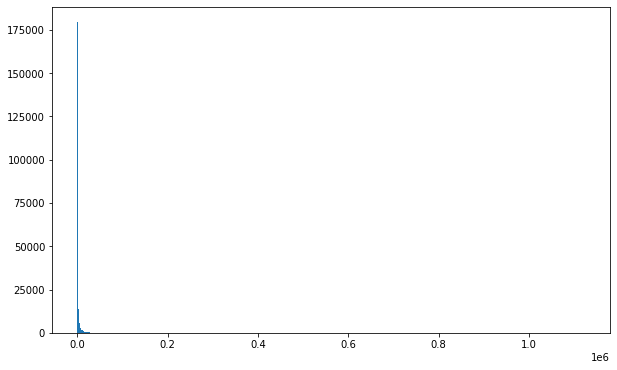

In [ ]:
plt.figure(figsize = (10, 6))
len_text = df['Text'].apply(lambda x: len(str(x).split())).values
plt.hist(len_text, bins=1000)
plt.show()

In [ ]:
len_text.shape

(257625,)

In [ ]:
len_text[len_text < 4096].shape

(225221,)

In [ ]:
len_text[len_text < 3072].shape

(215936,)

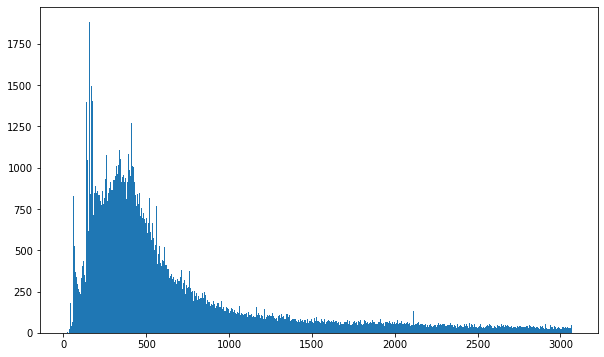

In [ ]:
plt.figure(figsize = (10, 6))
plt.hist(len_text[len_text < 3072], bins=1000)
plt.show()

In [ ]:
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_dicts[label]+=1
labels = pd.Series(label_dicts).to_frame()
labels.rename(columns={0:'cnt'}, inplace = True)
labels ['category'] = pd.cut(labels['cnt'], bins = [0, 1, 10, 50, 100, 500, 1000, 2500, 5000, 10000, 15000], labels = ['1label','10labels', '50labels', '100labels', '500labels', '1000labels', '2500labels', '5000labels', '10000labels', '15000labels',])
labels.sort_values(by='cnt')

,cnt,category
political philosophy,1,1label
Panama Canal,1,1label
Central Croatia,1,1label
Liberalism,1,1label
populism,1,1label
...,...,...
control of State aid,9231,10000labels
European Commission,9855,10000labels
State aid,11775,15000labels
merger control,12485,15000labels


In [ ]:
labels.groupby('category')['category'].count().to_frame()

,category
category,
1label,339
10labels,1313
50labels,1838
100labels,885
500labels,1582
1000labels,400
2500labels,245
5000labels,64
10000labels,24


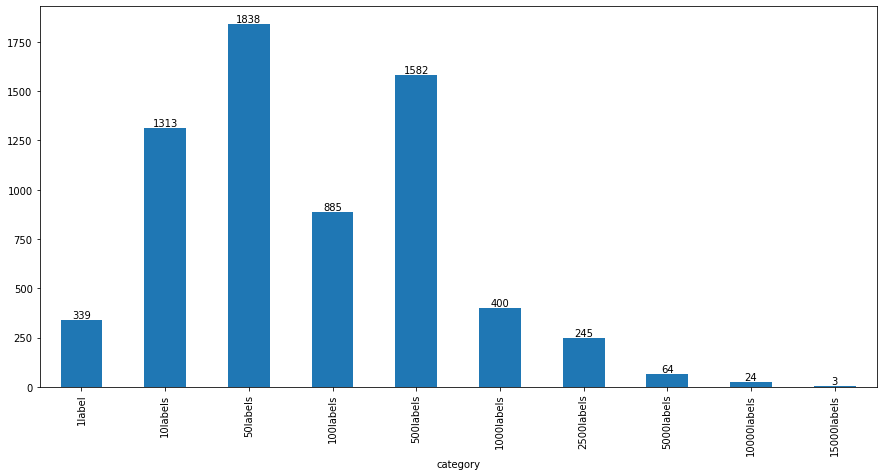

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
ax = labels.groupby('category')['category'].count().plot.bar()
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
filtered_labels = set(labels[(labels['category']== '15000labels') | 
                             (labels['category']== '10000labels') |
                             (labels['category']== '5000labels')].index)
filtered_labels

{'Belgium',
 'CCT duties',
 'China',
 'EU Member State',
 'EU aid',
 'EU financing',
 'EU programme',
 'EU trade mark',
 'European Commission',
 'European Economic Area',
 'European official',
 'European trademark',
 'France',
 'Germany',
 'Greece',
 'Italy',
 'Netherlands',
 'Portugal',
 'Spain',
 'State aid',
 'United Kingdom',
 'VAT',
 'accession to the European Union',
 'action for annulment of an EC decision',
 'action for failure to fulfil an obligation',
 'action programme',
 'agreement (EU)',
 'agricultural product',
 'aid to agriculture',
 'air transport',
 'anti-dumping duty',
 'application of EU law',
 'approximation of laws',
 'award of contract',
 'catch quota',
 'chemical product',
 'citrus fruit',
 'common organisation of markets',
 'consumer information',
 'consumer protection',
 'control of State aid',
 'cooperation policy',
 'designation of origin',
 'disclosure of information',
 'economic concentration',
 'economic sanctions',
 'environmental protection',
 'equal tre

In [ ]:
df['check_labels'] = df['labels'].apply(lambda x: any(label in filtered_labels for label in x))
print(np.unique(df['check_labels'], return_counts = True))
df = df[df['check_labels']]
df.head()

(array([False,  True]), array([ 58054, 199571]))


,CELEX,Text,labels,check_labels
1,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, tariff policy, agreement (EU), access...",True
3,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[trade agreement, Portugal, protocol to an agr...",True
4,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, customs harmonisati...",True
5,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,"[certificate of origin, joint committee (EU), ...",True
6,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,"[customs formalities, administrative cooperati...",True


In [ ]:
df['labels'] = df['labels'].apply(lambda x: [label for label in x if label in filtered_labels])
df.reset_index(drop=True, inplace = True)
df

,CELEX,Text,labels,check_labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[Portugal, protocol to an agreement, accession...",True
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, revision of an agre...",True
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,[originating product],True
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,[originating product],True
...,...,...,...,...
199566,E2019C1212(01),12.12.2019 EN Official Journal of the European...,"[State aid, European Economic Area, control of...",True
199567,E2019P0003,22.8.2019 EN Official Journal of the European ...,[equal treatment],True
199568,E2021C0121(01),21.1.2021 EN Official Journal of the European ...,[State aid],True
199569,E2021C0520(02),20.5.2021 EN Official Journal of the European ...,[European Economic Area],True


In [ ]:
label_sets = set()
label_dicts = defaultdict(int)
for labels in df['labels']:
    for label in labels:
        label_sets.add(label)
        if label not in label_dicts:
         label_dicts[label] = len(label_sets)
label_list = list(label_sets)

In [ ]:
len(label_list)

91

In [ ]:
df['enc_labels'] = df['labels'].apply(lambda labels: [label_dicts[label] for label in labels])
df.head()

,CELEX,Text,labels,check_labels,enc_labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True,"[1, 2, 3, 4]"
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[Portugal, protocol to an agreement, accession...",True,"[5, 6, 3, 7]"
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, revision of an agre...",True,"[6, 8]"
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,[originating product],True,[4]
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,[originating product],True,[4]


In [ ]:
def new_feature(targets):
    ntarget = []
    for a in range(1, len(label_list)+1):
        ntarget.append(1 if a in targets else 0)
    return ntarget
print(new_feature(df['enc_labels'][3]))
print(len(new_feature(df['enc_labels'][3])))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
91


In [ ]:
df['ohe_labels'] = df['enc_labels'].apply(lambda x: new_feature(x))
df.head()

,CELEX,Text,labels,check_labels,enc_labels,ohe_labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[Greece, agreement (EU), accession to the Euro...",True,"[1, 2, 3, 4]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[Portugal, protocol to an agreement, accession...",True,"[5, 6, 3, 7]","[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[protocol to an agreement, revision of an agre...",True,"[6, 8]","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,[originating product],True,[4],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,[originating product],True,[4],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df = df[['CELEX', 'Text', 'ohe_labels']]
df.head()

,CELEX,Text,ohe_labels
0,21980D1231(03),21980D1231(03) Decision No 3/80 of the EEC-Ice...,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,21986A1115(03),15.11.1986 EN Official Journal of the European...,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,21987A0720(02),20.7.1987 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,21987D0411(04),21987D0411(04) Decision No 3/86 of the EEC-Swe...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,21987D0411(05),21987D0411(05) Decision No 3/86 of the EEC-Swi...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_df, test_df = train_test_split(df, train_size = 0.8)

In [ ]:
train_size = 0.8
train_dataset=train_df.sample(frac=train_size,random_state=200)
test_dataset=train_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
train_dataset

,CELEX,Text,ohe_labels
0,31995R1031,31995R1031 Commission Regulation (EC) No 1031/...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,32006R0047,13.1.2006 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C2007/073/03,30.3.2007 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C2005/321/01,16.12.2005 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,52006IP0465,52006IP0465 European Parliament resolution on ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
127720,C2004/118/103,30.4.2004 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
127721,92002E003275,92002E3275 WRITTEN QUESTION E-3275/02 by Ioann...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
127722,32019R0364,22.3.2019 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
127723,31994R3316,31994R3316 Council Regulation (EC) No 3316/94 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test_dataset

,CELEX,Text,ohe_labels
0,62007CB0234(01),23.2.2008 EN Official Journal of the European ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,92003E001252,6.2.2004 EN Official Journal of the European U...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,31993D0448,31993D0448 93/448/EEC: Commission Decision of ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C2006/154/30,1.7.2006 EN Official Journal of the European U...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,52000PC0433,52000PC0433 Proposal for a Council Regulation ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
31926,32017R2089,15.11.2017 EN Official Journal of the European...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
31927,92003E003053,3.4.2004 EN Official Journal of the European U...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31928,32022D0217(03),17.2.2022 EN Official Journal of the European ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31929,91999E000099,91999E0099 WRITTEN QUESTION No. 99/99 by Honór...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [ ]:
# instantiate a Longformer for multilabel classification class
class LongformerForMultiLabelSequenceClassification(LongformerPreTrainedModel):
    """
    We instantiate a class of LongFormer adapted for a multilabel classification task. 
    This instance takes the pooled output of the LongFormer based model and passes it through a classification head. We replace the traditional Cross Entropy loss with a BCE loss that generate probabilities for all the labels that we feed into the model.
    """

    def __init__(self, config):
        super(LongformerForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.longformer = LongformerModel(config)
        self.classifier = LongformerClassificationHead(config)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None, 
                token_type_ids=None, position_ids=None, inputs_embeds=None, 
                labels=None):
        
        # create global attention on sequence, and a global attention token on the `s` token
        # the equivalent of the CLS token on BERT models. This is taken care of by HuggingFace
        # on the LongformerForSequenceClassification class
        if global_attention_mask is None:
            global_attention_mask = torch.zeros_like(input_ids)
            global_attention_mask[:, 0] = 1
        
        # pass arguments to longformer model
        outputs = self.longformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            global_attention_mask = global_attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids)
        
        # if specified the model can return a dict where each key corresponds to the output of a
        # LongformerPooler output class. In this case we take the last hidden state of the sequence
        # which will have the shape (batch_size, sequence_length, hidden_size). 
        sequence_output = outputs['last_hidden_state']
        
        # pass the hidden states through the classifier to obtain thee logits
        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            labels = labels.float()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.view(-1, self.num_labels))
            #outputs = (loss,) + outputs
            outputs = (loss,) + outputs
        
        
        return outputs

In [ ]:
# instantiate a class that will handle the data
class Data_Processing(object):
    def __init__(self, tokenizer, id_column, text_column, label_column):
        
        # define the text column from the dataframe
        self.text_column = text_column.tolist()
    
        # define the label column and transform it to list
        self.label_column = label_column
        
        # define the id column and transform it to list
        self.id_column = id_column.tolist()
        
    
# iter method to get each element at the time and tokenize it using bert        
    def __getitem__(self, index):
        comment_text = str(self.text_column[index])
        comment_text = " ".join(comment_text.split())
        # encode the sequence and add padding
        inputs = tokenizer.encode_plus(comment_text,
                                       add_special_tokens = True,
                                       max_length= 3072,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       truncation = True,
                                       return_tensors='pt')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        labels_ = torch.tensor(self.label_column[index], dtype=torch.float)
        id_ = self.id_column[index]
        return {'input_ids':input_ids[0], 'attention_mask':attention_mask[0], 
                'labels':labels_, 'id_':id_}
  
    def __len__(self):
        return len(self.text_column) 

In [ ]:
batch_size = 32

In [ ]:
# create a class to process the training and test data
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096', 
                                                    padding = 'max_length',
                                                    truncation=True, 
                                                    max_length = 3072)

In [ ]:
training_data = Data_Processing(tokenizer, 
                                train_dataset['CELEX'], 
                                train_dataset['Text'], 
                                train_dataset['ohe_labels'])

In [ ]:
test_data =  Data_Processing(tokenizer, 
                             test_dataset['CELEX'], 
                             test_dataset['Text'], 
                             test_dataset['ohe_labels'])

In [ ]:
# use the dataloaders class to load the data
dataloaders_dict = {'train': DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=32),
                    'val': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=32)
                   }

In [ ]:
dataset_sizes = {'train':len(training_data),
                 'val':len(test_data)
                }

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = LongformerForMultiLabelSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                  gradient_checkpointing=False,
                                                  attention_window = 512,
                                                  num_labels = len(label_list),
                                                  cache_dir=data_dir+'model_all_data/',
                                                  return_dict=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForMultiLabelSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForMultiLabelSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.d

In [ ]:
def multi_label_metrics(predictions, 
                        labels, 
    ):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_true = labels
    y_pred[np.where(probs >= 0.5)] = 1
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # define dictionary of metrics to return
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

In [ ]:
# Use the aux EvalPrediction class to obtain prediction labels
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
training_args = TrainingArguments(
    output_dir = data_dir + 'results_all',
    group_by_length=True,
    length_column_name='input_length',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=64,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=1000,
    save_strategy='steps', # we cannot set it to "no". Otherwise, the model cannot guess the best checkpoint.
    eval_steps=1000,
    logging_steps=1000,
    learning_rate=5e-5,
    warmup_steps=500,
    save_total_limit=3,
    report_to="none",
    load_best_model_at_end = True, # this will let the model save the best checkpoint
    run_name = 'longformer_multilabel_trainer_3072_2e5a'
)

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_data,
    eval_dataset=test_data,
    compute_metrics = compute_metrics,
    #data_collator = Data_Processing(),
)

Using amp half precision backend


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
trainer.train()

# device = torch.device("cuda:1;2;3" if torch.cuda.is_available() else "cpu")
# model=torch.nn.DataParallel(trainer)
# model.to(device)



cuda


/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 127725
  Num Epochs = 4
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 64
  Total optimization steps = 996
The following columns in the training set don't have a corresponding argument in `LongformerForMultiLabelSequenceClassification.forward` and have been ignored: id_. If id_ are not expected by `LongformerForMultiLabelSequenceClassification.forward`,  you can safely ignore this message.
/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to ga

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=996, training_loss=0.16093290091518417, metrics={'train_runtime': 59182.3121, 'train_samples_per_second': 8.633, 'train_steps_per_second': 0.017, 'total_flos': 1.0124926184249856e+18, 'train_loss': 0.16093290091518417, 'epoch': 4.0})

In [ ]:
trainer.model.save_pretrained(data_dir+'trained_model_all_data/longformer_base_multilabel_3072_2e5')
tokenizer.save_pretrained(data_dir+'tokenizer_all_data/longformer_base_multilabel_3072_2e5')

Configuration saved in trained_model_all_data/longformer_base_multilabel_3072_2e5/config.json
Model weights saved in trained_model_all_data/longformer_base_multilabel_3072_2e5/pytorch_model.bin
tokenizer config file saved in tokenizer_all_data/longformer_base_multilabel_3072_2e5/tokenizer_config.json
Special tokens file saved in tokenizer_all_data/longformer_base_multilabel_3072_2e5/special_tokens_map.json


('tokenizer_all_data/longformer_base_multilabel_3072_2e5/tokenizer_config.json',
 'tokenizer_all_data/longformer_base_multilabel_3072_2e5/special_tokens_map.json',
 'tokenizer_all_data/longformer_base_multilabel_3072_2e5/vocab.json',
 'tokenizer_all_data/longformer_base_multilabel_3072_2e5/merges.txt',
 'tokenizer_all_data/longformer_base_multilabel_3072_2e5/added_tokens.json',
 'tokenizer_all_data/longformer_base_multilabel_3072_2e5/tokenizer.json')

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 31931
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `LongformerForMultiLabelSequenceClassification.forward` and have been ignored: id_. If id_ are not expected by `LongformerForMultiLabelSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.07506756484508514,
 'eval_f1': 0.2820133510684585,
 'eval_roc_auc': 0.5824185316046362,
 'eval_accuracy': 0.03701731859321662,
 'eval_runtime': 1052.7555,
 'eval_samples_per_second': 30.331,
 'eval_steps_per_second': 0.948,
 'epoch': 4.0}

In [ ]:
# instantiate a class that will handle the data
class Data_Processing_test():
    def __init__(self, tokenizer, id_column, text_column):
        
        # define the text column from the dataframe
        self.text_column = text_column.tolist()
                    
        # define the id column and transform it to list
        self.id_column = id_column.tolist()
            
# iter method to get each element at the time and tokenize it using bert        
    def __getitem__(self, index):
        comment_text = str(self.text_column[index])
        comment_text = " ".join(comment_text.split())
        
        inputs = tokenizer.encode_plus(comment_text,
                                       add_special_tokens = True,
                                       max_length= 2048,
                                       padding = 'max_length',
                                       return_attention_mask = True,
                                       truncation = True,
                                       return_tensors='pt')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        id_ = self.id_column[index]
        return {'input_ids':input_ids[0], 'attention_mask':attention_mask[0], 
                'id_':id_}
  
    def __len__(self):
        return len(self.text_column) 

In [ ]:
batch_size = 32
# create a class to process the traininga and test data

test_data_pred =  Data_Processing_test(tokenizer,
                                       test_df['CELEX'], 
                                       test_df['Text'])

# use the dataloaders class to load the data
dataloaders_dict = {'test': DataLoader(test_data_pred,
                                                 batch_size=batch_size, shuffle=True, num_workers=32)}

In [ ]:
def prediction():
    prediction_data_frame_list = []
    with torch.no_grad():
        trainer.model.eval()
        for i, batch in enumerate(dataloaders_dict['test']):
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # feed the sequences to the model, specifying the attention mask
            outputs = model(inputs, attention_mask=attention_mask)
            # feed the logits returned by the model to the softmax to classify the function
            sigmoid = torch.nn.Sigmoid()
            probs = sigmoid(torch.Tensor(outputs[0].detach().cpu().data.numpy()))
            #probs.
            probs = np.array(probs)
            #print(np.array([[i] for i in probs]))
            y_pred = np.zeros(probs.shape)
            y_pred = probs
            temp_data = pd.DataFrame(zip(batch['id_'], probs), columns = ['id', 'target'
                                                                         ])
            #print(temp_data)
            prediction_data_frame_list.append(temp_data)                

    prediction_df = pd.concat(prediction_data_frame_list)
    prediction_df[label_list] = pd.DataFrame(prediction_df.target.tolist(),
                                                                                index= prediction_df.index)
    prediction_df = prediction_df.drop(columns = 'target')
    return prediction_df

predictions = prediction()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

In [ ]:
predictions

,id,restriction on competition,market approval,foodstuff,State aid,export refund,disclosure of information,equal treatment,human rights,international sanctions,...,merger control,anti-dumping duty,aid to agriculture,China,protocol to an agreement,registered trademark,European Economic Area,EU Member State,economic sanctions,health control
0,91998E000437,0.028182,0.030356,0.021341,0.023393,0.021765,0.017208,0.030152,0.021694,0.032105,...,0.019691,0.022573,0.019997,0.046587,0.027230,0.038547,0.027325,0.068156,0.023657,0.026216
1,C2010/044/04,0.014771,0.032468,0.016659,0.021008,0.018833,0.016467,0.028171,0.022625,0.041808,...,0.035830,0.144178,0.018683,0.019424,0.025177,0.031660,0.022214,0.045766,0.024674,0.026864
2,52004PC0333,0.019275,0.031821,0.028097,0.116301,0.014080,0.032006,0.020827,0.022841,0.018974,...,0.016542,0.019114,0.022943,0.020643,0.016127,0.023500,0.020992,0.018025,0.018153,0.015214
3,32001D0095,0.035440,0.029849,0.021085,0.031470,0.032108,0.028455,0.111768,0.019816,0.023742,...,0.022043,0.021801,0.018337,0.028717,0.022259,0.021494,0.018134,0.034696,0.016207,0.025158
4,32021R0280,0.018802,0.047739,0.023070,0.037504,0.018650,0.022058,0.021504,0.042533,0.032289,...,0.016647,0.036401,0.015177,0.028475,0.019664,0.019452,0.016408,0.032372,0.014382,0.015629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,62018TN0413,0.016876,0.018404,0.011770,0.013103,0.013066,0.010385,0.024533,0.013015,0.021091,...,0.015375,0.011551,0.007828,0.024541,0.011409,0.013348,0.009084,0.022820,0.009950,0.011013
7,52004PC0602,0.023685,0.173637,0.048253,0.047066,0.023464,0.117271,0.031923,0.073242,0.035779,...,0.022164,0.019645,0.019180,0.024579,0.021531,0.015359,0.018297,0.022914,0.022416,0.026443
8,92002E002140,0.033405,0.029443,0.025491,0.020263,0.021269,0.013744,0.048280,0.018000,0.161494,...,0.031284,0.015806,0.009734,0.025050,0.014985,0.017455,0.018482,0.026479,0.012849,0.019656
9,91997E002047,0.028474,0.022867,0.018154,0.019886,0.028340,0.016765,0.077702,0.016561,0.023320,...,0.019166,0.014421,0.011198,0.030156,0.017716,0.019988,0.014094,0.040466,0.018429,0.026427


In [ ]:
rm_id = np.random.randint(len(test_df))
idx =  predictions.iloc[rm_id, 0]
ohe_labels = test_df[test_df['CELEX'] == idx]['ohe_labels'].sum()
for i in range(len(ohe_labels)):
    if ohe_labels[i]==1:
        print(label_list[i])

citrus fruit
award of contract


In [ ]:
predictions

,id,restriction on competition,market approval,foodstuff,State aid,export refund,disclosure of information,equal treatment,human rights,international sanctions,...,merger control,anti-dumping duty,aid to agriculture,China,protocol to an agreement,registered trademark,European Economic Area,EU Member State,economic sanctions,health control
0,91998E000437,0.028182,0.030356,0.021341,0.023393,0.021765,0.017208,0.030152,0.021694,0.032105,...,0.019691,0.022573,0.019997,0.046587,0.027230,0.038547,0.027325,0.068156,0.023657,0.026216
1,C2010/044/04,0.014771,0.032468,0.016659,0.021008,0.018833,0.016467,0.028171,0.022625,0.041808,...,0.035830,0.144178,0.018683,0.019424,0.025177,0.031660,0.022214,0.045766,0.024674,0.026864
2,52004PC0333,0.019275,0.031821,0.028097,0.116301,0.014080,0.032006,0.020827,0.022841,0.018974,...,0.016542,0.019114,0.022943,0.020643,0.016127,0.023500,0.020992,0.018025,0.018153,0.015214
3,32001D0095,0.035440,0.029849,0.021085,0.031470,0.032108,0.028455,0.111768,0.019816,0.023742,...,0.022043,0.021801,0.018337,0.028717,0.022259,0.021494,0.018134,0.034696,0.016207,0.025158
4,32021R0280,0.018802,0.047739,0.023070,0.037504,0.018650,0.022058,0.021504,0.042533,0.032289,...,0.016647,0.036401,0.015177,0.028475,0.019664,0.019452,0.016408,0.032372,0.014382,0.015629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,62018TN0413,0.016876,0.018404,0.011770,0.013103,0.013066,0.010385,0.024533,0.013015,0.021091,...,0.015375,0.011551,0.007828,0.024541,0.011409,0.013348,0.009084,0.022820,0.009950,0.011013
7,52004PC0602,0.023685,0.173637,0.048253,0.047066,0.023464,0.117271,0.031923,0.073242,0.035779,...,0.022164,0.019645,0.019180,0.024579,0.021531,0.015359,0.018297,0.022914,0.022416,0.026443
8,92002E002140,0.033405,0.029443,0.025491,0.020263,0.021269,0.013744,0.048280,0.018000,0.161494,...,0.031284,0.015806,0.009734,0.025050,0.014985,0.017455,0.018482,0.026479,0.012849,0.019656
9,91997E002047,0.028474,0.022867,0.018154,0.019886,0.028340,0.016765,0.077702,0.016561,0.023320,...,0.019166,0.014421,0.011198,0.030156,0.017716,0.019988,0.014094,0.040466,0.018429,0.026427


In [ ]:
predictions.to_csv(data_dir+'predictions.csv', index = False)

In [ ]:
predictions.set_index('id', inplace = True)
predictions.T

id,91998E000437,C2010/044/04,52004PC0333,32001D0095,32021R0280,92004E001027,31970D0244,62009FA0080,32006R1490,22019D1623,...,52017DC0497,62012CN0051,62015FN0026,31988R2659,31998D0088,62018TN0413,52004PC0602,92002E002140,91997E002047,52007AP0059
restriction on competition,0.028182,0.014771,0.019275,0.035440,0.018802,0.027134,0.016460,0.035560,0.040923,0.052639,...,0.025906,0.021733,0.024195,0.017660,0.023363,0.016876,0.023685,0.033405,0.028474,0.016718
market approval,0.030356,0.032468,0.031821,0.029849,0.047739,0.031518,0.027688,0.032983,0.061547,0.104611,...,0.036303,0.020234,0.027598,0.025549,0.033989,0.018404,0.173637,0.029443,0.022867,0.019209
foodstuff,0.021341,0.016659,0.028097,0.021085,0.023070,0.021130,0.020427,0.022551,0.038357,0.039788,...,0.024740,0.015557,0.017757,0.013675,0.040738,0.011770,0.048253,0.025491,0.018154,0.015192
State aid,0.023393,0.021008,0.116301,0.031470,0.037504,0.022626,0.013478,0.023946,0.051812,0.046223,...,0.018492,0.020668,0.019740,0.025699,0.112728,0.013103,0.047066,0.020263,0.019886,0.022447
export refund,0.021765,0.018833,0.014080,0.032108,0.018650,0.024536,0.011755,0.027366,0.054060,0.037407,...,0.018655,0.016959,0.017726,0.017536,0.019543,0.013066,0.023464,0.021269,0.028340,0.013870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
registered trademark,0.038547,0.031660,0.023500,0.021494,0.019452,0.021668,0.022434,0.057783,0.065647,0.026889,...,0.042164,0.013141,0.029568,0.021280,0.019314,0.013348,0.015359,0.017455,0.019988,0.011842
European Economic Area,0.027325,0.022214,0.020992,0.018134,0.016408,0.017957,0.016762,0.034841,0.066282,0.027889,...,0.027898,0.011846,0.020844,0.013033,0.020120,0.009084,0.018297,0.018482,0.014094,0.010184
EU Member State,0.068156,0.045766,0.018025,0.034696,0.032372,0.036269,0.017382,0.033465,0.039711,0.045604,...,0.022312,0.075318,0.031115,0.019242,0.031550,0.022820,0.022914,0.026479,0.040466,0.024432
economic sanctions,0.023657,0.024674,0.018153,0.016207,0.014382,0.011203,0.017773,0.071181,0.064074,0.033903,...,0.047794,0.010004,0.022515,0.015432,0.021878,0.009950,0.022416,0.012849,0.018429,0.007562


In [ ]:
pred_transform = predictions.T.copy()
top_5 = pd.DataFrame(index = predictions.index, columns = ['Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5', 'labels'])
for col in pred_transform.columns:
    ohe_labels = test_df[test_df['CELEX'] == col]['ohe_labels'].sum()
    labels = []
    for i in range(len(ohe_labels)):
        if ohe_labels[i]==1:
            labels.append(label_list[i])
    
    top_5.loc[col] = list(predictions.T[col].nlargest(5).items()) + [tuple(labels)]
    
top_5

/home/ruslan/anaconda3/envs/lformer/lib/python3.7/site-packages/pandas/core/internals/blocks.py:937: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


,Top_1,Top_2,Top_3,Top_4,Top_5,labels
id,,,,,,
91998E000437,"(exchange rate, 0.09552431106567383)","(EU Member State, 0.0681559219956398)","(tariff quota, 0.06676582992076874)","(Portugal, 0.05142801254987717)","(EU aid, 0.050350453704595566)","(exchange rate,)"
C2010/044/04,"(Belgium, 0.7661889791488647)","(originating product, 0.7276022434234619)","(anti-dumping duty, 0.14417822659015656)","(Portugal, 0.08258581906557083)","(EU Member State, 0.04576558619737625)","(originating product, Portugal, Belgium)"
52004PC0333,"(Greece, 0.14574216306209564)","(import price, 0.13708089292049408)","(application of EU law, 0.13496723771095276)","(State aid, 0.116301029920578)","(air transport, 0.07031702250242233)","(air transport,)"
32001D0095,"(provision of services, 0.5500628352165222)","(action for annulment of an EC decision, 0.390...","(European trademark, 0.19074667990207672)","(equal treatment, 0.11176825314760208)","(European Commission, 0.09600978344678879)","(consumer protection, provision of services, E..."
32021R0280,"(Portugal, 0.09036609530448914)","(Germany, 0.08113507926464081)","(action for failure to fulfil an obligation, 0...","(labelling, 0.07790736854076385)","(EU programme, 0.05705288425087929)","(import,)"
...,...,...,...,...,...,...
62018TN0413,"(tariff quota, 0.035353563725948334)","(EU aid, 0.027479737997055054)","(Portugal, 0.027301158756017685)","(European trademark, 0.02528485469520092)","(provision of services, 0.025105534121394157)","(China,)"
52004PC0602,"(market approval, 0.17363710701465607)","(disclosure of information, 0.11727146804332733)","(human rights, 0.07324224710464478)","(EU programme, 0.058185312896966934)","(Portugal, 0.04878293350338936)","(market approval, public health)"
92002E002140,"(international sanctions, 0.16149426996707916)","(EU trade mark, 0.1211545318365097)","(tariff quota, 0.06787299364805222)","(general budget (EU), 0.06711077690124512)","(Portugal, 0.05466931685805321)","(Portugal, EU trade mark)"


In [ ]:
top_5.to_csv('top_5.csv')

In [ ]:
top_5.sample(10)

,Top_1,Top_2,Top_3,Top_4,Top_5,labels
id,,,,,,
32015R2382,"(Germany, 0.2391938865184784)","(United Kingdom, 0.05186885595321655)","(Belgium, 0.034133534878492355)","(Portugal, 0.032223932445049286)","(catch quota, 0.029611391946673393)","(Germany,)"
31974D0233,"(provision of services, 0.06981675326824188)","(originating product, 0.05381670966744423)","(Belgium, 0.04862241446971893)","(European Commission, 0.046958547085523605)","(action for annulment of an EC decision, 0.045...","(single market,)"
52020M9814(01),"(Belgium, 0.7612669467926025)","(originating product, 0.7181789875030518)","(anti-dumping duty, 0.14203326404094696)","(Portugal, 0.07784036546945572)","(EU Member State, 0.04502130299806595)","(originating product, Belgium)"
32005D0768,"(import (EU), 0.14908596873283386)","(pip fruit, 0.12663353979587555)","(tariff quota, 0.08575364202260971)","(EU aid, 0.07422150671482086)","(European trademark, 0.0740935280919075)","(pip fruit, technical standard)"
22006D0078,"(EU programme, 0.2298380434513092)","(human rights, 0.11834235489368439)","(Germany, 0.08792395889759064)","(market approval, 0.08257915824651718)","(import licence, 0.06478159129619598)","(fishing area,)"
31989D0177,"(provision of services, 0.2986298203468323)","(action for annulment of an EC decision, 0.186...","(European trademark, 0.08343714475631714)","(equal treatment, 0.07185303419828415)","(European Commission, 0.05134843289852142)","(export refund, provision of services)"
31987R2930,"(provision of services, 0.040061887353658676)","(European trademark, 0.03646623715758324)","(tariff quota, 0.03501481935381889)","(EU aid, 0.03005935810506344)","(European Commission, 0.029051538556814194)","(CCT duties,)"
92001E002489,"(EU aid, 0.45200884342193604)","(health control, 0.08956689387559891)","(economic sanctions, 0.07243645191192627)","(registered trademark, 0.056721653789281845)","(equal treatment, 0.050925202667713165)","(EU aid,)"
62006TB0058,"(EU aid, 0.5486142039299011)","(provision of services, 0.2541925609111786)","(action for annulment of an EC decision, 0.191...","(health control, 0.17833292484283447)","(European trademark, 0.1268921047449112)","(provision of services, technical standard, EU..."
